# Tutorial 5: Enrichment analysis

We performed Gene Ontology (GO) analysis on identified spatially variable genes (SVGs) of raw and enhanced mouse hippocampus Slide-seq dataset.

In [1]:
library(clusterProfiler)
library(org.Mm.eg.db)
library(AnnotationDbi)
library(enrichplot)
library(stringr)
library(ggplot2)



clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, p

In [2]:
keytypes(org.Mm.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"

In [3]:
pair_enrichgo <- function(path1, path2, sig_value="pvalue", sig_threshold=0.05){
    DE_raw <- read.csv(path1)
    DE_stasite <- read.csv(path2)
    DE_raw <- DE_raw[DE_raw$FDR<0.001,]
    DE_stasite <- DE_stasite[DE_stasite$FDR<0.001,]
    DE_raw_gene <- DE_raw$Gene
    DE_stasite_gene <- DE_stasite$Gene
    DE_raw_gene <- str_to_title(DE_raw_gene)
    DE_stasite_gene <- str_to_title(DE_stasite_gene)
    DE_raw_ID <- bitr(DE_raw_gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db)$ENTREZID
    DE_stasite_ID <- bitr(DE_stasite_gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db)$ENTREZID
    enrichment1 <- enrichGO(DE_raw_gene, keyType = "SYMBOL", OrgDb = org.Mm.eg.db)
    enrichment2 <- enrichGO(DE_stasite_gene, keyType = "SYMBOL", OrgDb = org.Mm.eg.db)
    results1 <- enrichment1@result[enrichment1@result$pvalue < sig_threshold,c("Description",sig_value,"Count")]
    results2 <- enrichment2@result[enrichment2@result$pvalue < sig_threshold,c("Description",sig_value,"Count")]
    results <- list(results1, results2)
    return(results)
}

In [4]:
results_all <- pair_enrichgo("T5/results/hotspot_results_raw.csv", "T5/results/hotspot_results_staloc.csv")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(DE_raw_gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db):
"5.22% of input gene IDs are fail to map..."
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(DE_stasite_gene, fromType = "SYMBOL", toType = "ENTREZID", :
"11.87% of input gene IDs are fail to map..."


In [5]:
common_results <- merge(results_all[[1]], results_all[[2]], by="Description")
common_results <- common_results[,c(1,2,4)]
colnames(common_results)[2:3] <- c("Raw","STALOC")
common_results <- common_results[order(common_results$Raw, decreasing=F),]

In [6]:
head(common_results)

,Description,Raw,STALOC
,<chr>,<dbl>,<dbl>
54,channel regulator activity,6.252991e-11,7.055615e-17
106,ion channel regulator activity,6.184277e-10,1.037813e-15
40,calmodulin binding,7.291494e-10,6.431506e-30
74,G protein-coupled receptor binding,2.087139e-08,1.014745e-05
111,L-glutamate transmembrane transporter activity,1.043722e-07,6.054911e-04
204,structural constituent of myelin sheath,2.161791e-07,1.226244e-02


In [7]:
top_results_svg <- results_all[[2]]
top_results_svg <- top_results_svg[-which(top_results_svg$Description %in% results_all[[1]]$Description),]
top_results_svg <- top_results_svg[order(top_results_svg$pvalue), ]
top_results_svg <- top_results_svg[1:10,]
top_results_svg$Description <- factor(top_results_svg$Description, levels = rev(top_results_svg$Description))

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


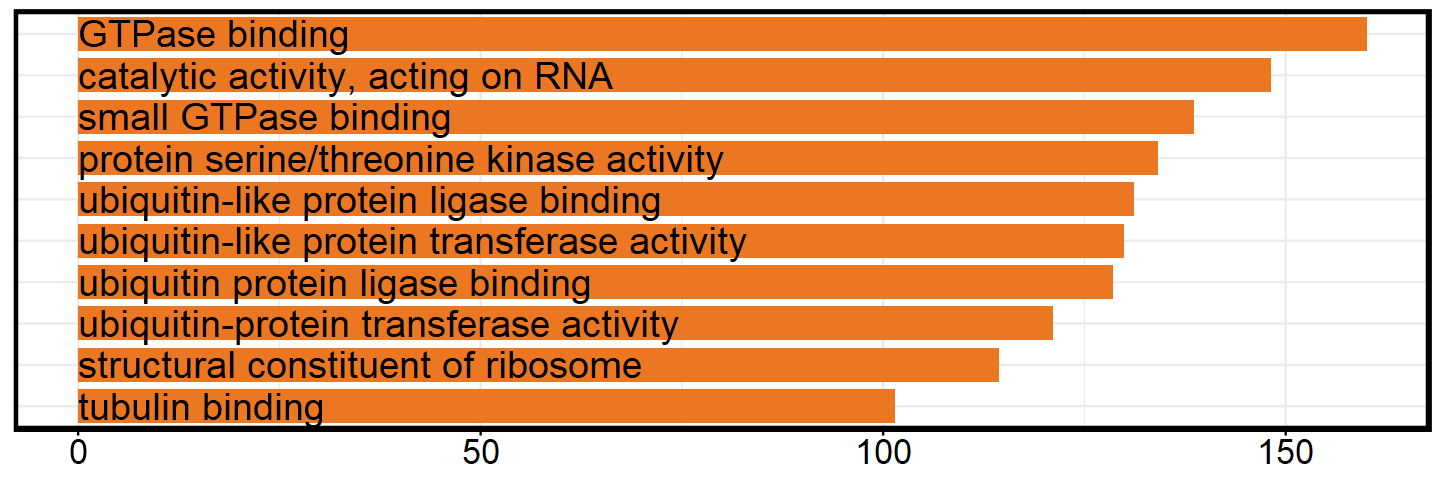

In [8]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(top_results_svg, aes(x = -log(pvalue), y = Description)) +
    geom_bar(fill = "#ec7722", width = .8, position = 'dodge', stat = "identity") +
    geom_text(aes(label = Description, x = 0), hjust = 0, size = 8) +
    scale_x_continuous(breaks = seq(0,200,50))+
    theme_bw() +
    labs(x="",y="",fill="") + 
    theme(axis.text.y = element_blank(), 
          axis.ticks.y = element_blank(),
          axis.title.y = element_blank(),
          plot.title = element_text(hjust = 0, size = 20),
          plot.subtitle = element_text(hjust = 0, size = 20),
          axis.text.x = element_text(hjust = 0.5, size = 20, color = "black"),
          axis.title.x = element_blank(),
          axis.ticks.x = element_line(color = "black"),
          legend.position = c(0.8,0.9),
          legend.title = element_text(size = 15),
          legend.text  = element_text(size = 15),
          legend.key.size = unit(1, "lines"),
          panel.border = element_rect(color = "black", size = 2))